In [1]:
import torch
import torch.nn as nn
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from torch.autograd.function import Function
import numpy as np
import torch.utils.data as Data
import math
from torch.utils.data import DataLoader
import torch.optim as optim
import copy
import time
from torch.optim import Adam
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler
import matplotlib.pyplot as plt

from torch import randperm
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import train_test_split

import argparse

In [2]:
#We use the kaggle platform, so we need to download the Lion optimizer related packages every time.
#!pip install lion-pytorch
#!pip install triton -U --pre
#from lion_pytorch import Lion

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
parser = argparse.ArgumentParser()
parser.add_argument('-f', type=str, default="读取额外的参数")
parser.add_argument('--bs', type=int, default=256, help='Batch size')
parser.add_argument('--float', type=int, default=5e-4, help='Learning rate')
parser.add_argument('--epoch', type=int, default=200, help='Epoch')
args = parser.parse_args(args=[])

#load data
train_x = torch.from_numpy(np.load('/root/HAR/dataset/WISDM/x_train.npy')).float()
train_y = torch.from_numpy(np.load('/root/HAR/dataset/WISDM/y_train.npy')).long()
test_x = torch.from_numpy(np.load('/root/HAR/dataset/WISDM/x_test.npy')).float()
test_y = torch.from_numpy(np.load('/root/HAR/dataset/WISDM/y_test.npy')).long()

# train_x = torch.unsqueeze(train_x, 1)
# test_x = torch.unsqueeze(test_x, 1)
# train_x = train_x.reshape(train_x.size(0), 1, train_x.size(1), train_x.size(2))
# test_x = test_x.reshape(test_x.size(0), 1, test_x.size(1),test_x.size(2))
# num_classes = len(Counter(train_y.tolist()))
len_train, len_test = len(train_y),  len(test_y)

train_data, val_data, train_label, val_label = train_test_split(train_x, train_y, test_size=0.15, random_state=18)

train_dataset = Data.TensorDataset(train_data, train_label)
val_dataset = Data.TensorDataset(val_data, val_label)
test_dataset = Data.TensorDataset(test_x, test_y)

# train_loader = Data.DataLoader(dataset=train_dataset, batch_size=args.bs, shuffle=True)
# test_loader = Data.DataLoader(dataset=test_dataset, batch_size=args.bs, shuffle=True)
# val_loader = Data.DataLoader(dataset=val_dataset, batch_size=args.bs, shuffle=True)

In [4]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, size_average=True):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.centerlossfunc = CenterlossFunc.apply
        self.feat_dim = feat_dim
        self.size_average = size_average

    def forward(self, label, feat):
        batch_size = feat.size(0)
        feat = feat.view(batch_size, -1)
        # To check the dim of centers and features
        if feat.size(1) != self.feat_dim:
            raise ValueError("Center's dim: {0} should be equal to input feature's \
                            dim: {1}".format(self.feat_dim,feat.size(1)))
        batch_size_tensor = feat.new_empty(1).fill_(batch_size if self.size_average else 1)
        loss = self.centerlossfunc(feat, label, self.centers, batch_size_tensor)
        return loss


class CenterlossFunc(Function):
    @staticmethod
    def forward(ctx, feature, label, centers, batch_size):
        ctx.save_for_backward(feature, label, centers, batch_size)
        centers_batch = centers.index_select(0, label.long())
        return (feature - centers_batch).pow(2).sum() / 2.0 / batch_size

    @staticmethod
    def backward(ctx, grad_output):
        feature, label, centers, batch_size = ctx.saved_tensors
        centers_batch = centers.index_select(0, label.long())
        diff = centers_batch - feature
        # init every iteration
        counts = centers.new_ones(centers.size(0))
        ones = centers.new_ones(label.size(0))
        grad_centers = centers.new_zeros(centers.size())

        counts = counts.scatter_add_(0, label.long(), ones)
        grad_centers.scatter_add_(0, label.unsqueeze(1).expand(feature.size()).long(), diff)
        grad_centers = grad_centers/counts.view(-1, 1)
        return - grad_output * diff / batch_size, None, grad_centers / batch_size, None

In [5]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("使用GPU训练中：{}".format(torch.cuda.get_device_name()))
else:
    device = torch.device("cpu")
    print("使用CPU训练")

使用GPU训练中：NVIDIA GeForce RTX 4090


In [6]:
class Shrinkage_SE(nn.Module):
    def __init__(self, channel,spilt =4,gap_size = 1):
        super(Shrinkage_SE, self).__init__()

        self.gap = nn.AdaptiveAvgPool1d(gap_size)
        self.attention = nn.Sequential(
            nn.Linear(channel, channel//16),
            nn.ReLU(inplace=True),
            nn.Linear(channel//16, channel), 
            nn.Sigmoid()
        )
        self.fc = nn.Sequential(
            nn.Linear(channel, channel),
            nn.ReLU(inplace=True),
            nn.Linear(channel, channel),
            nn.Sigmoid(),
        )

    def forward(self, x):
        
        x_raw = x
        x = torch.abs(x)

        x_abs = x
        x = self.gap(x)
        x = torch.flatten(x, 1)
        #attn = self.attention(x)##
        # average = torch.mean(x, dim=1, keepdim=True)  #CS
        average = x    #CW
        x = self.fc(x)
        x = torch.mul(average, x)
        x = x.unsqueeze(2)
        #attn = attn.unsqueeze(2)
        # soft thresholding
        sub = x_abs - x
        #sub = x_abs - attn*x

        zeros = sub - sub
        n_sub = torch.max(sub, zeros)
        x = torch.mul(torch.sign(x_raw), n_sub)
        return x
    
class Shrinkage_ECA(nn.Module):
    def __init__(self, channel, gap_size=1):
        super(Shrinkage_ECA, self).__init__()
        self.gap = nn.AdaptiveAvgPool1d(gap_size)
        self.attention = nn.Sequential(
            nn.Linear(channel, channel//16),
            nn.ReLU(inplace=True),
            nn.Linear(channel//16, channel), 
            nn.Sigmoid()
        )
        self.ECA = ECA(channel, k_size=3)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel),
            nn.ReLU(inplace=True),
            nn.Linear(channel, channel),
            nn.Sigmoid(),
        )

    def forward(self, x):
        
        x_raw = x
        x = torch.abs(x)
        #attn = self.attention(x)##
        attn = self.ECA(x)
        x_abs = x
        x = self.gap(x)
        x = torch.flatten(x, 1)
        #attn = self.attention(x)##
        # average = torch.mean(x, dim=1, keepdim=True)  #CS
        average = x    #CW
        x = self.fc(x)
        x = torch.mul(average, x)
        x = x.unsqueeze(2)
        #attn = attn.unsqueeze(2)
        # soft thresholding
        #sub = x_abs - x
        sub = x_abs - attn*x
        
        zeros = sub - sub
        n_sub = torch.max(sub, zeros)
        x = torch.mul(torch.sign(x_raw), n_sub)
        return x
class ECA(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)
        # Two different branches of ECA module
        y = self.conv(y.transpose(-1, -2)).transpose(-1, -2)
        # Multi-scale information fusion
        y = self.sigmoid(y)
        return x * y.expand_as(x)

In [7]:



#model =  g1(mod='ECA',inplanes=3).to(device)
#model =  g2(mod='ECA',inplanes=3).to(device)
#model =  g3(mod='ECA',inplanes=3).to(device)


In [8]:
batch_size = 512
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True,drop_last=True, num_workers=2,)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=2,)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=2,)


In [9]:
def train(model, train_dataloader,val_dataloader, num_epochs=50, lr1 = 0.001,lr2 = 0.003,loss_weight = 0.007):
    # 定义损失函数和优化器.
    criterion1 = nn.CrossEntropyLoss()
    criterion2 = CenterLoss(6, 6).to(device)
    optimizer1 = Adam(model.parameters(), lr = lr1)
    optimizer2 = Adam(criterion2.parameters(), lr = lr1)
    #optimizer1 = Lion(model.parameters(), lr = lr1, weight_decay=1.0)
    #optimizer2 = Lion(criterion2.parameters(), lr = lr2, weight_decay=1.0)
    # 定义存储训练和验证结果的列表.
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    # 定义在验证集上表现最好的模型准确率和损失.
    best_val_acc = 0.0
    best_val_loss = float('inf')
    Best_epoch=0
    # 定义存储最佳模型参数的变量.
    best_model_params = None
    # 开始训练模型.
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()
        for i, (inputs, labels) in enumerate(train_dataloader):
            model.train()
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 将梯度清零.
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            
            # 前向传播.
            outputs = model(inputs)

            # 计算损失和准确率.
            loss = criterion1(outputs, labels)+loss_weight*criterion2(labels,outputs)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # 反向传播和更新参数.
            loss.backward()
            optimizer1.step()
            optimizer2.step()
            # 累计训练损失
            train_loss += loss.item()
            print(">",end="")
        # 计算训练准确率和损失.
        train_acc = 100.0 * train_correct / train_total
        train_loss = train_loss / len(train_dataloader)

        # 在验证集上验证模型.
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            
            for i, (inputs, labels) in enumerate(val_dataloader):
                # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
                model.eval()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 前向传播.
                outputs = model(inputs)

                # 计算损失和准确率.
                loss = criterion1(outputs, labels)+loss_weight*criterion2(labels,outputs,)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # 累计验证损失.
                val_loss += loss.item()

        
        # 计算验证准确率和损失.
        val_acc = 100.0 * val_correct / val_total
        val_loss = val_loss / len(val_dataloader)
        if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
            Best_epoch =epoch+1
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_params = model.state_dict()
        
        print()
        # 打印训练和验证结果.
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))
        
        # 保存训练和验证结果.
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    print("The best epoch:",Best_epoch,"    Acc:",best_val_acc)
    model.load_state_dict(best_model_params)
    # 返回训练和验证结果.
    return model.eval(),train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [10]:
def conv3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1(in_planes, out_planes, stride=1):
    """1x1 convolution"""

    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class SEModule(nn.Module):
    def __init__(self, channels, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Conv1d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv1d(channels // reduction, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.avg_pool(input)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input * x

class EfficientChannelAttention(nn.Module):           # Efficient Channel Attention module
    def __init__(self, c, b=1, gamma=2):
        super(EfficientChannelAttention, self).__init__()
        t = int(abs((math.log(c, 2) + b) / gamma))
        k = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv1 = nn.Conv1d(1, 1, kernel_size=k, padding=int(k/2), bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = x
        x = self.avg_pool(x)
        x = self.conv1(x.transpose(-1, -2)).transpose(-1, -2)
        out = self.sigmoid(x)
        return out+y

class GatedRes2NetBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, downsample=None,
                 stride=1, scales=4, groups=1, mod='ECA', norm_layer=None):
        super(GatedRes2NetBottleneck, self).__init__()
        if planes * groups % scales != 0:
            raise ValueError('Planes must be divisible by scales')
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        bottleneck_planes = groups * planes
        self.conv1 = conv1(inplanes, bottleneck_planes, stride)
        self.bn1 = norm_layer(bottleneck_planes)
        self.conv2 = nn.ModuleList([conv3(bottleneck_planes // scales,
                                          bottleneck_planes // scales,
                                          groups=groups) for _ in range(scales - 1)])
        self.SE = nn.ModuleList([EfficientChannelAttention(bottleneck_planes // scales) for _ in range(scales - 1)])
        self.bn2 = nn.ModuleList([norm_layer(bottleneck_planes // scales)
                                  for _ in range(scales - 1)])
        self.judge = nn.ModuleList([conv1(bottleneck_planes+2*bottleneck_planes // scales,
                                          bottleneck_planes // scales
                                          ) for _ in range(scales - 2)])
        self.tanh = nn.Tanh()

        self.Shrinkage_SE = Shrinkage_SE(channel = 4*planes,spilt = planes//16)
        self.Shrinkage_ECA = Shrinkage_ECA(channel = 4*planes)
        self.conv3 = conv1(bottleneck_planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.model=mod
        if mod == 'ECA':
            self.mod = EfficientChannelAttention(self.expansion*planes)
        elif mod == 'SE':
            self.mod = SEModule(self.expansion*planes)
        
        self.downsample = downsample
        self.stride = stride
        self.scales = scales

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        xs = torch.chunk(out, self.scales, 1)
        ys = []
        before = []
        att = []
        for s in range(self.scales):
            if s == 0:
                ys.append(xs[s])
            
            elif s == 1:
                ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s]))))
                before.append(ys[-1])
                ys[-1] = (self.SE[s - 1](ys[-1]))
            else:
                #gate = self.tanh(self.judge[s - 2](torch.cat([out,xs[s],ys[-1]],dim=1)))
                #ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s] + gate * ys[-1]))))
                ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s]))))
                before.append(ys[-1])
                att.append(before[-2]+ys[-2])
                ys[-1] = self.SE[s - 1](ys[-1]+att[-1])


        out = torch.cat(ys, 1)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.model =='SE':
            out = self.mod(out)
        elif self.model == 'ECA':
            x = self.mod(out)
            out= out+x
        out = self.Shrinkage_ECA(out)
        if self.downsample is not None:
            identity = self.downsample(identity)

        out = out + identity
        out = self.relu(out)

        return out
#########
#
class GatedFCN(nn.Module):
    def __init__(self, layers, maxlength=6, groups=1,
                  width=8,scales=4,mod='ECA', norm_layer=None,inplanes=128):
        super(GatedFCN, self).__init__()
        planes = [int(width * scales * 2 ** i) for i in range(4)]
        #planes=torch.tensor(planes)
        #planes=planes.to('cuda')
        self.pre=inplanes
        self.inplanes=planes[0]
        self.maxlength=maxlength

        self.pre=conv1(inplanes,planes[0])

        self.layer1 = self._make_layer(GatedRes2NetBottleneck, planes[0], layers[0], scales=scales, groups=groups, mod=mod,
                                       norm_layer=norm_layer)
        
        self.layer2 = self._make_layer(GatedRes2NetBottleneck, planes[1], layers[1], stride=2, scales=scales, groups=groups,
                                       mod=mod, norm_layer=norm_layer)

        self.layer3 = self._make_layer(GatedRes2NetBottleneck, planes[2], layers[2], stride=2, scales=scales, groups=groups,
                                       mod=mod, norm_layer=norm_layer)

        self.layer4 = self._make_layer(GatedRes2NetBottleneck, planes[3], layers[3], stride=2, scales=scales, groups=groups,
                                       mod=mod, norm_layer=norm_layer)

        self.roi=nn.AdaptiveAvgPool1d(output_size=1)
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.15)
        self.dropout3 = nn.Dropout(p=0.2)
        self.dropout4 = nn.Dropout(p=0.25)
        self.mapping=conv1(in_planes=1024 ,out_planes=maxlength)
        #self.Context_Encoder = Context_Encoder(1024, 512).to(device)
        #self.Context_Encoder = Context_Encoder(12, 6).to(device)
        self.preluip1 = nn.PReLU()
    def _make_layer(self, block, planes, block_num, stride=1, scales=4, groups=1, mod='ECA', norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, downsample, stride=stride, scales=scales, groups=groups, mod=mod,
                            norm_layer=norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, block_num):
            layers.append(block(self.inplanes, planes, scales=scales, groups=groups, mod=mod, norm_layer=norm_layer))
        
        return nn.Sequential(*layers)

    def forward(self,x):
        x=  x.to(device)
        x = x.permute(0, 2, 1)

        x=  self.pre(x)
        x1 = self.dropout1(x)
        x1=  self.layer1(x1)
        
        
        x2 = self.dropout2(x1)
        #print(x2.shape)
        x2 = self.layer2(x2)
        
        x3 = self.dropout3(x2)
        x3 = self.layer3(x3)

        x4 = self.dropout4(x3)
        x4 = self.layer4(x4)

        #x4 = self.Context_Encoder.forward_ret(x4)

        x5=  self.roi(x4)
        

        output=self.mapping(x5)

        output=output.squeeze()

        return output

In [11]:
def g1(mod='None',inplanes=3):
    return GatedFCN([1,2,2,1],mod=mod,inplanes=inplanes)
def g2(mod='None',inplanes=36):
    return GatedFCN([1,2,1,0],mod=mod,inplanes=inplanes)
def g3(mod='None',inplanes=36):
    return GatedFCN([2,3,4,1],mod=mod,inplanes=inplanes)
model1 =  g1(mod='None',inplanes=3).to(device)
model2 =  g2(mod='None',inplanes=3).to(device)
model3 =  g3(mod='None',inplanes=3).to(device)

In [12]:
start_time = time.time()
model,train_loss_list, train_acc_list, val_loss_list, val_acc_list=\
train(model1, train_dataloader, val_dataloader, num_epochs=50,lr1 = 0.001,lr2 = 0.003,loss_weight = 0)
end_time = time.time()
use_time= end_time - start_time
print("Train and val complete in {:.0f}m {:.0f}s".format(use_time // 60, use_time % 60))
# print("Train and val complete in {:.0f}m {:.0f}s".format(use_time // 60, use_time % 60))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [1/50], Train Loss: 0.5516, Train Acc: 79.39%, Val Loss: 0.4095, Val Acc: 84.90%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [2/50], Train Loss: 0.2725, Train Acc: 90.06%, Val Loss: 0.2337, Val Acc: 91.32%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [3/50], Train Loss: 0.1858, Train Acc: 93.38%, Val Loss: 0.2344, Val Acc: 91.70%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [4/50], Train Loss: 0.1448, Train Acc: 94.79%, Val Loss: 0.3125, Val Acc: 90.62%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [5/50], Train Loss: 0.1268, Train Acc: 95.46%, Val Loss: 0.1562, Val Acc: 94.52%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [6/50], Train Loss: 0.1068, Train Acc: 96.25%, Val Loss: 0.1606, Val Acc: 94.04%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [13]:
torch.save(model, 'msap_wisdm_model.pt')

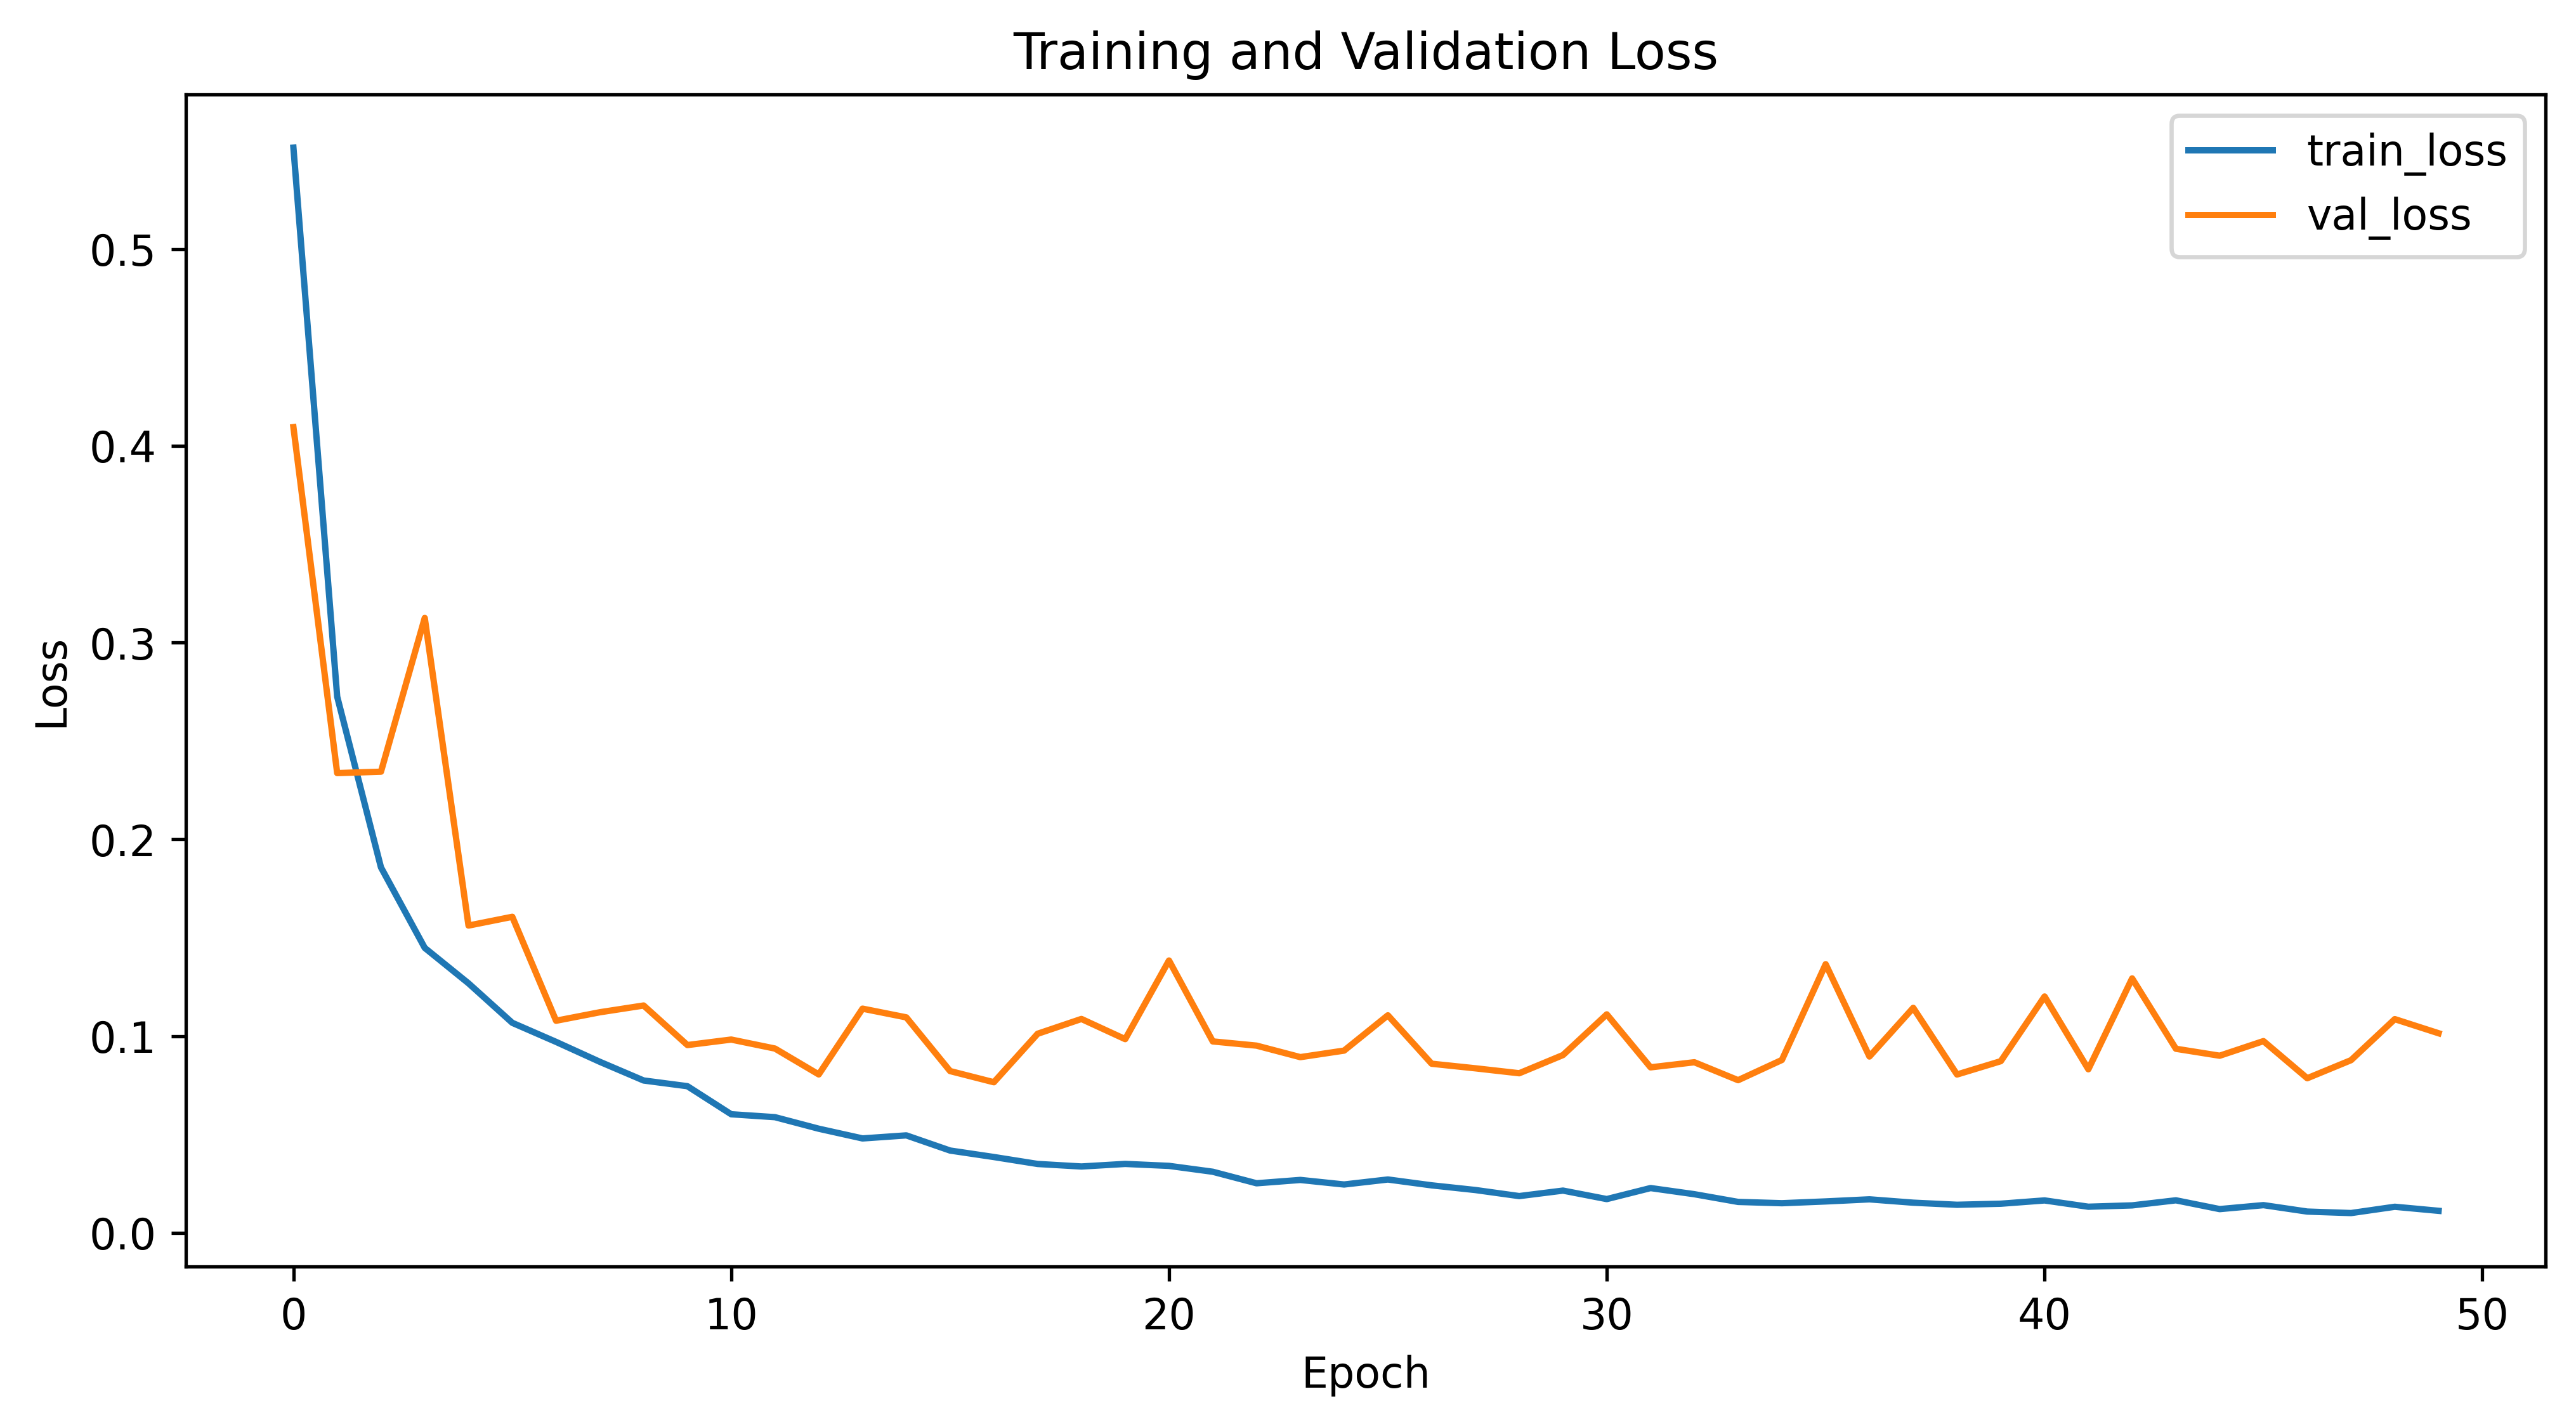

<Figure size 640x480 with 0 Axes>

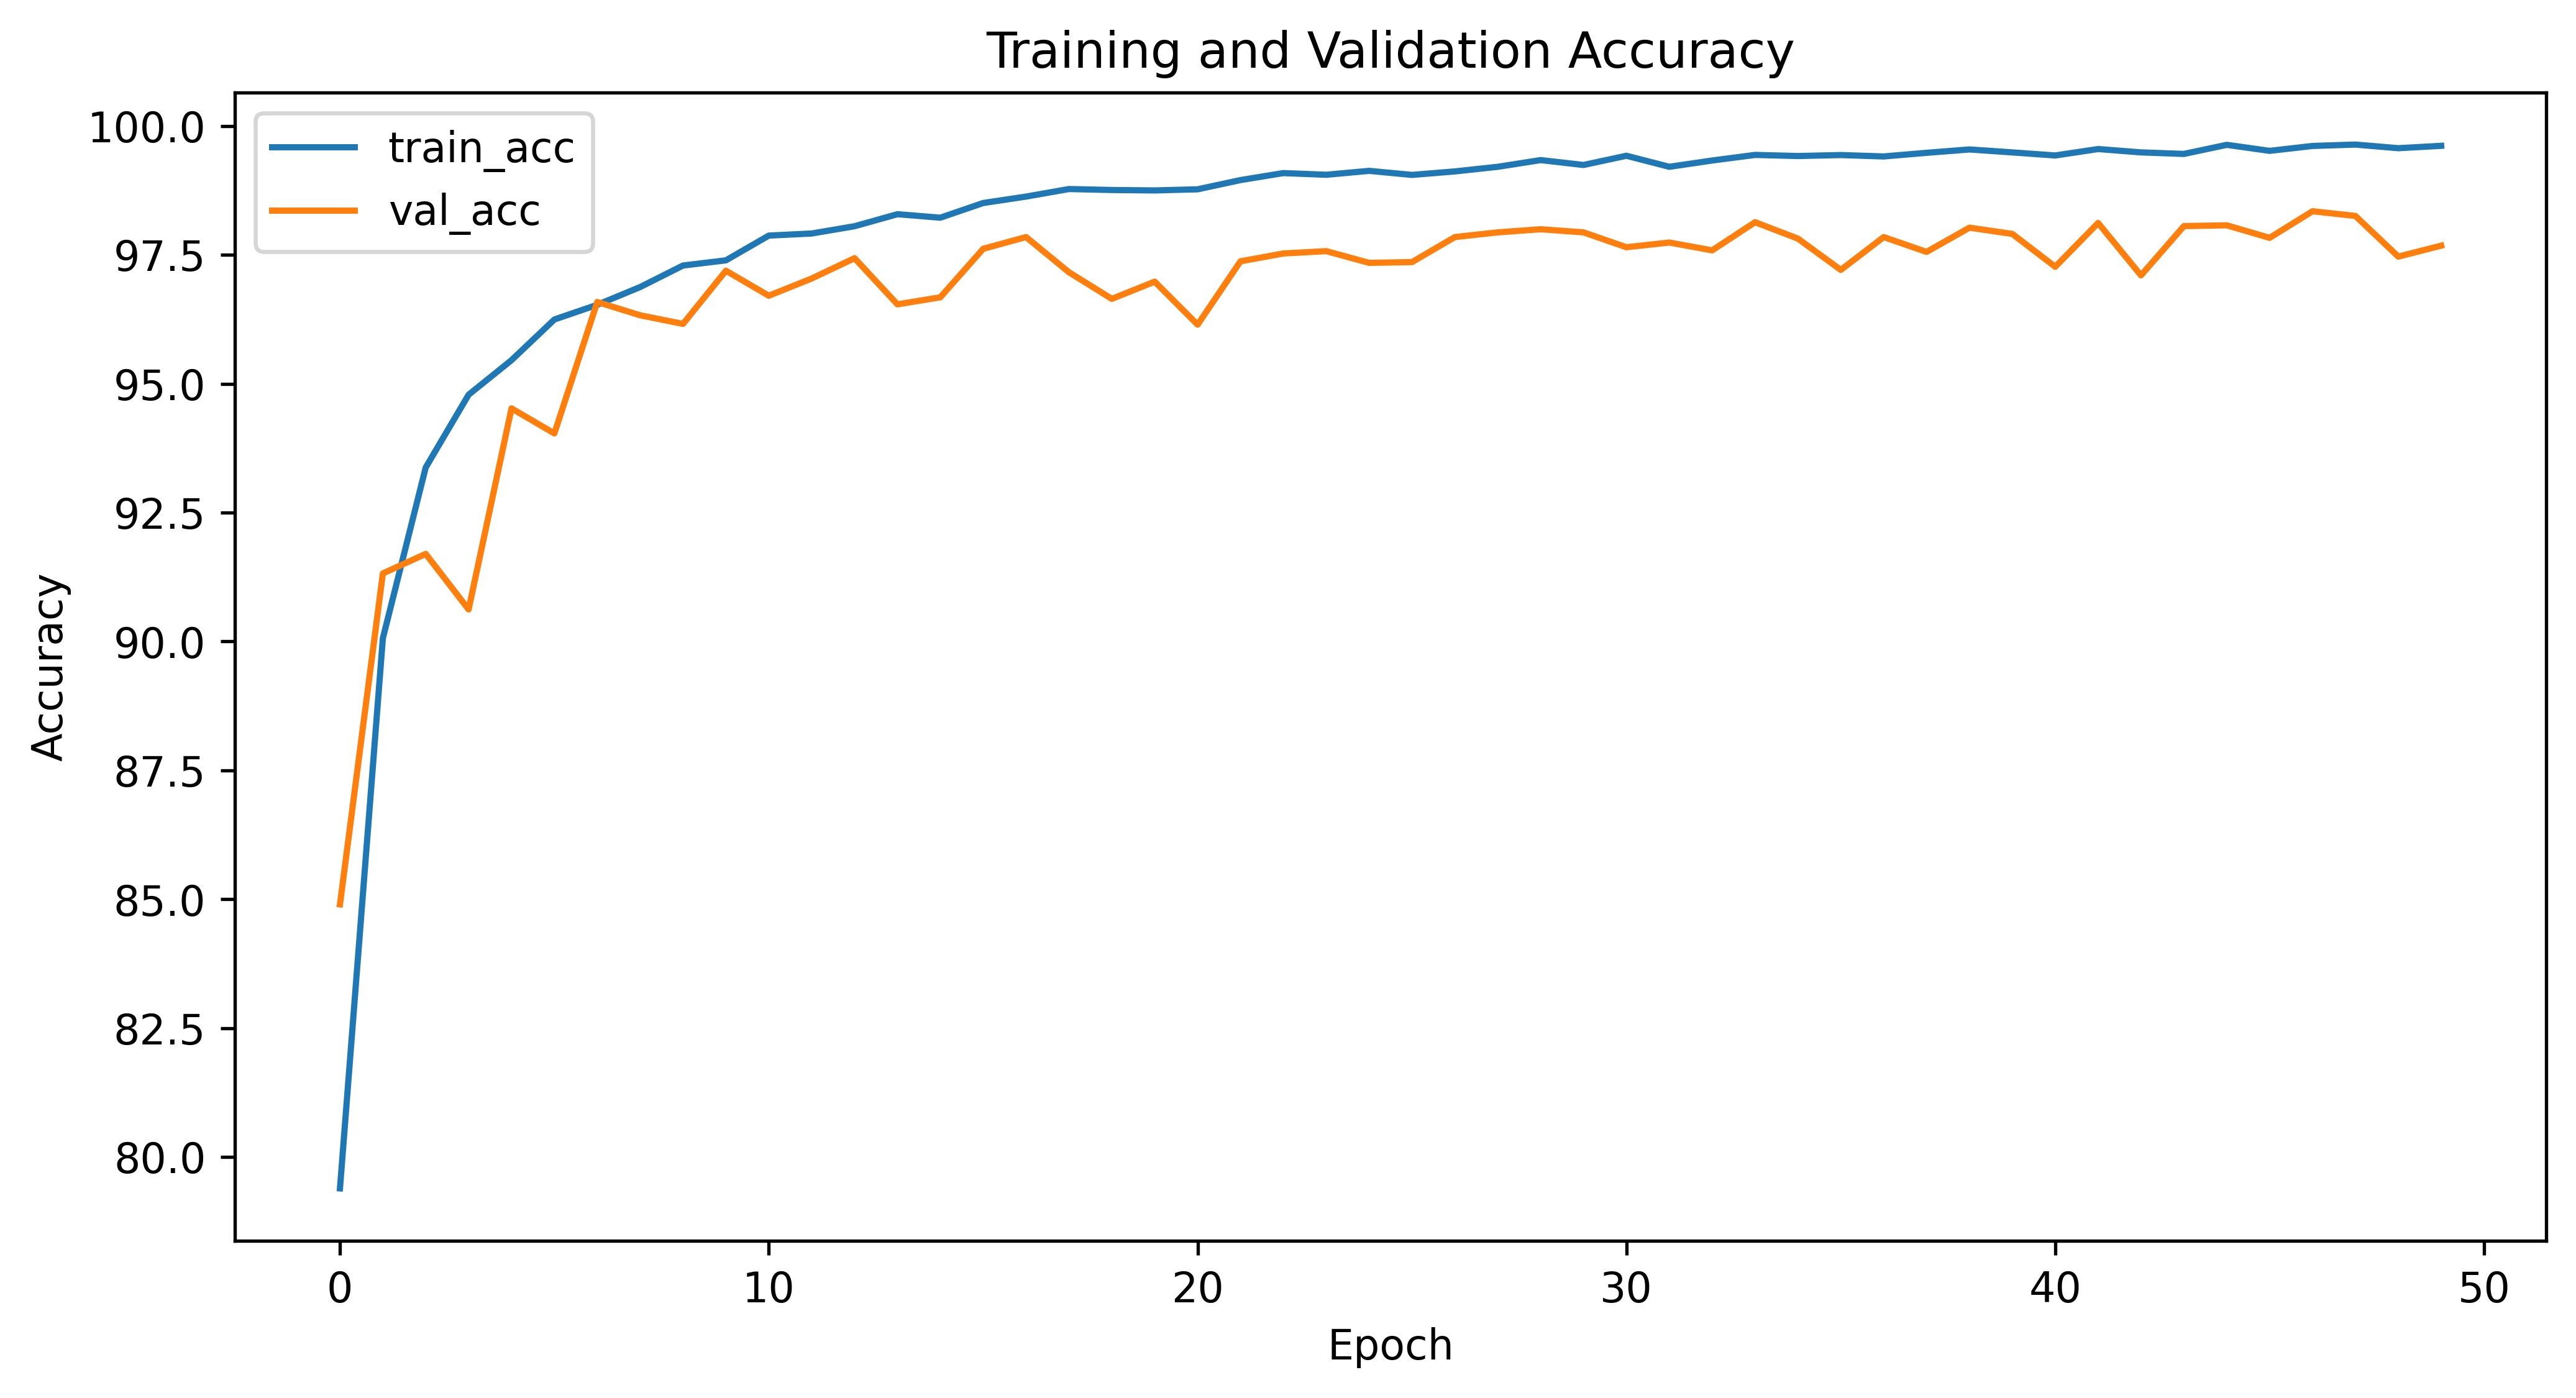

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    # 绘制训练和验证损失
    plt.figure(figsize=(10, 5),dpi=480)
    plt.plot(train_loss_list, label='train_loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig('loss')

    # 绘制训练和验证准确率
    plt.figure(figsize=(10, 5),dpi=480)
    plt.plot(train_acc_list, label='train_acc')
    plt.plot(val_acc_list, label='val_acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('acc')
plot_loss_and_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list)


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
def test_final(model, test_dataloader,loss_weight = 0.007):
    # 将模型设置为测试模式.
    model.eval()

       # 定义损失函数和优化器.
    criterion1 = nn.CrossEntropyLoss()
    criterion2 = CenterLoss(6, 6).to(device)

    loss_weight=0.007
    # 在测试集上测试模型.
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []
    num_classes = 6
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  # 创建混淆矩阵
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 前向传播.
            outputs = model(inputs)
            pre_lab = torch.argmax(outputs, 1)
            # 计算损失和准确率.
            #loss = criterion1(outputs, labels)
            loss = criterion1(outputs, labels) + loss_weight * criterion2(labels, outputs)
            _, predicted = torch.max(
                                     outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # 累计测试损失.
            test_loss += loss.item()
            y_true.extend(labels.tolist())
            y_pred.extend(pre_lab.tolist())
            conf_matrix += confusion_matrix(labels.cpu(), pre_lab.cpu(), labels=range(num_classes))
    report = classification_report(y_true, y_pred,digits=4)
    g_mean = np.sqrt(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1))
    g_mean = np.mean(g_mean)

    # 更新分类报告
    report += '\nG-mean: {:.4f}'.format(g_mean)
    # 计算测试准确率和损失.
    test_acc = 100.0 * test_correct / test_total
    test_loss = test_loss / len(test_dataloader)

    # 打印测试结果.
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(test_loss, test_acc))
    print(report)
    # 返回测试结果.
    return test_loss, test_acc

In [16]:
test_loss, test_acc=test_final(model, test_dataloader,loss_weight = 0)

Test Loss: 3.7048, Test Acc: 97.79%
              precision    recall  f1-score   support

           0     0.9513    0.8865    0.9177      1013
           1     0.9997    0.9842    0.9919      3481
           2     0.9983    0.9849    0.9916       596
           3     0.9737    1.0000    0.9867       482
           4     0.8870    0.9702    0.9267      1173
           5     0.9913    0.9932    0.9922      4237

    accuracy                         0.9779     10982
   macro avg     0.9669    0.9698    0.9678     10982
weighted avg     0.9787    0.9779    0.9780     10982

G-mean: 0.9846


开始绘制混淆矩阵


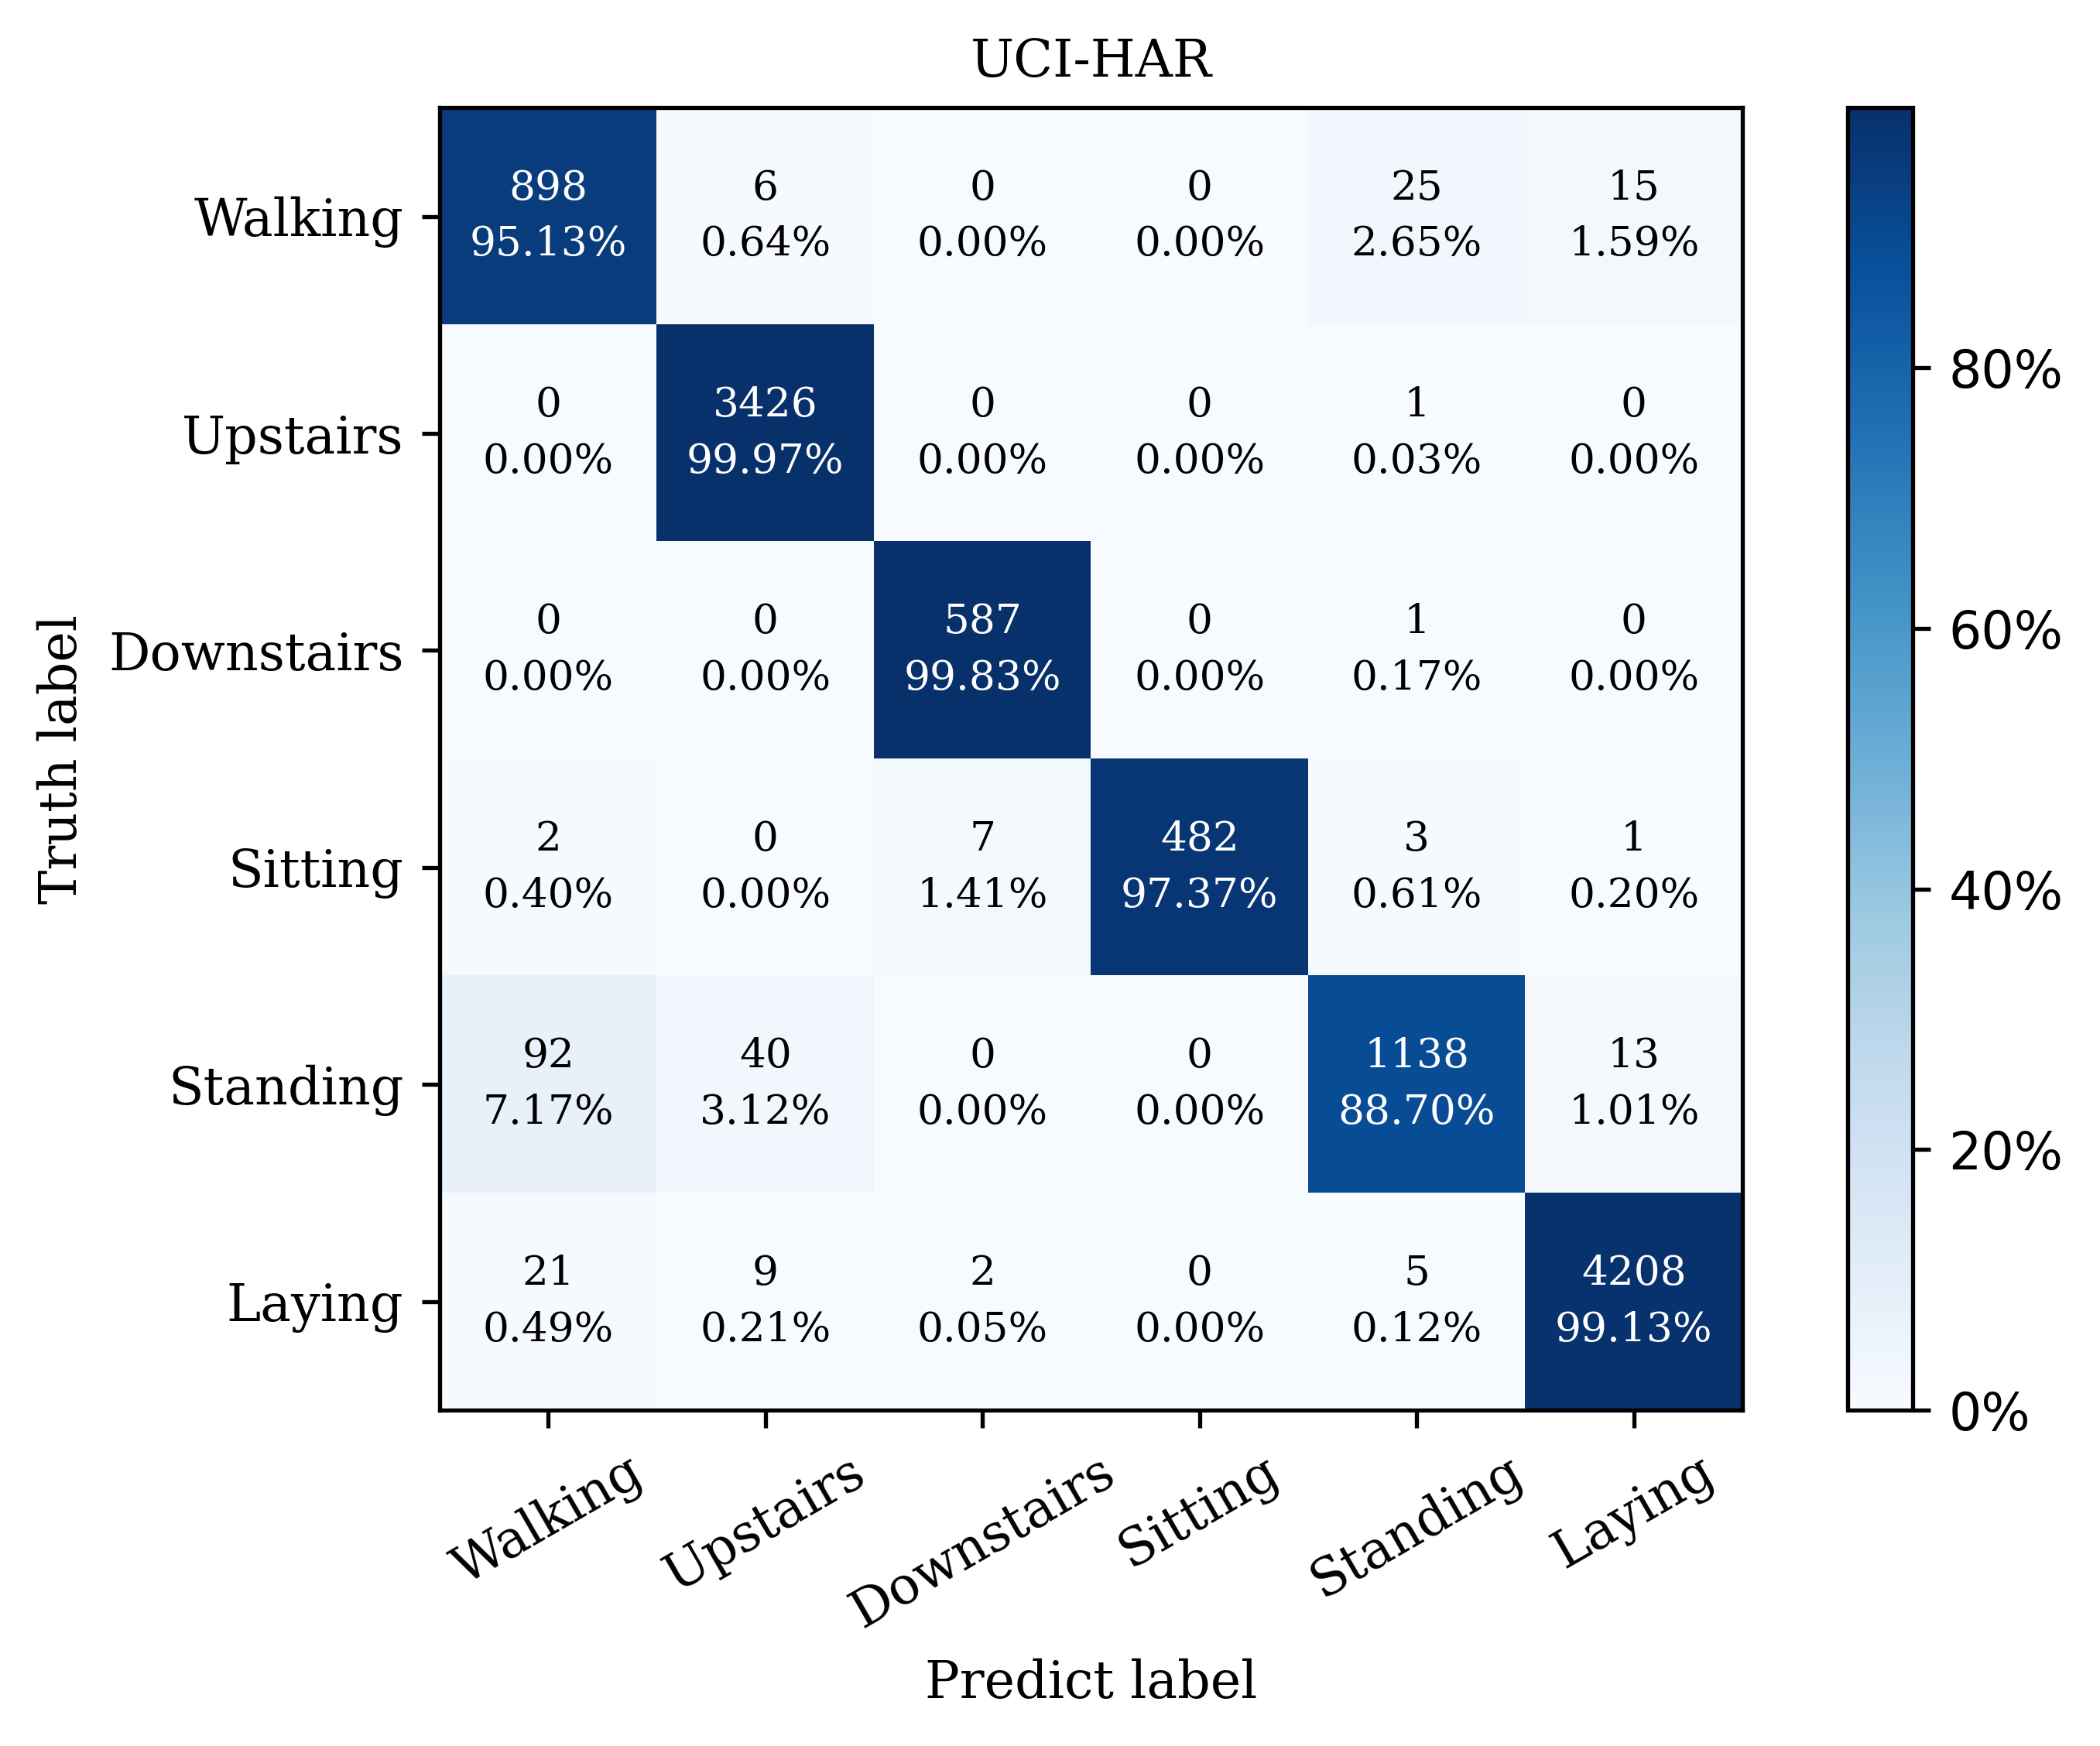

[[9.512e-01 6.400e-03 0.000e+00 0.000e+00 2.650e-02 1.590e-02]
 [0.000e+00 9.997e-01 0.000e+00 0.000e+00 3.000e-04 0.000e+00]
 [0.000e+00 0.000e+00 9.983e-01 0.000e+00 1.700e-03 0.000e+00]
 [4.000e-03 0.000e+00 1.410e-02 9.738e-01 6.100e-03 2.000e-03]
 [7.170e-02 3.120e-02 0.000e+00 0.000e+00 8.870e-01 1.010e-02]
 [4.900e-03 2.100e-03 5.000e-04 0.000e+00 1.200e-03 9.913e-01]]


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import PercentFormatter
class DrawConfusionMatrix:
    def __init__(self, labels_name, normalize=True):
        self.normalize = normalize
        self.labels_name = labels_name
        self.num_classes = len(labels_name)
        self.matrix = np.zeros((self.num_classes, self.num_classes), dtype="float32")
        self.class_counts_matrix = np.zeros((self.num_classes, self.num_classes), dtype="int32")

    def update(self, labels, predicts):
        for predict, label in zip(labels, predicts):
            self.matrix[label, predict] += 1
            self.class_counts_matrix[label, predict] += 1

    def getMatrix(self, normalize=True):
        if normalize:
            per_sum = self.matrix.sum(axis=1)  # 计算每行的和，用于百分比计算
            for i in range(self.num_classes):
                self.matrix[i] = (self.matrix[i] / per_sum[i])  # 百分比转换
            self.matrix = np.around(self.matrix, 4)  # 保留4位小数点
            self.matrix[np.isnan(self.matrix)] = 0.0  # 可能存在NaN，将其设为0
        return self.matrix

    def drawMatrix(self):
        self.matrix = self.getMatrix(self.normalize)
        font = FontProperties(family='serif', style='normal', weight='normal', size=10)
        plt.figure(dpi=480)
        plt.imshow(self.matrix, cmap=plt.cm.Blues)  # 仅画出颜色格子，没有值
        plt.title("UCI-HAR", fontproperties=font)  # 标题
        plt.xlabel("Predict label", fontproperties=font)
        plt.ylabel("Truth label", fontproperties=font)

        plt.yticks(range(self.num_classes), self.labels_name, fontproperties=font)  # y轴标签
        plt.xticks(range(self.num_classes), self.labels_name, rotation=30, fontproperties=font)  # x轴标签
        thresh = self.matrix.max() / 2.

        for x in range(self.num_classes):
            for y in range(self.num_classes):
                count = self.class_counts_matrix[y, x]
                value = str(format('%.2f' % float(self.matrix[y, x] * 100.00))) + '%'  # 数值处理
                #text = f"{count}\n{value}"
                text = count
                plt.text(x, y-0.13, text, verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if self.matrix[y, x] > thresh else "black", fontproperties=font, fontsize=8)  # 写值
                plt.text(x, y+0.13, value, verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if self.matrix[y, x] > thresh else "black", fontproperties=font, fontsize=8)  # 写值

        plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

        #色条
        plt.colorbar(format=PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
        plt.savefig('./ConfusionMatrix.png', bbox_inches='tight')  # bbox_inches='tight'可确保标签信息显示全
        plt.show()


def printMatrix(test_loader, model):
#     labels_name = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
    labels_name=["Walking", "Upstairs", "Downstairs", "Sitting", "Standing", "Laying"]

    drawconfusionmatrix = DrawConfusionMatrix(labels_name=labels_name)  # 实例化
    for index, (imgs, labels) in enumerate(test_loader, 1):
        labels_pd = model(imgs.float())
        predict_np = np.argmax(labels_pd.cpu().detach().numpy(), axis=-1)  # array([0,5,1,6,3,...],dtype=int64)
        labels_np = labels.numpy()  # array([0,5,0,6,2,...],dtype=int64)
        drawconfusionmatrix.update(labels_np, predict_np)  # 将新批次的predict和label更新（保存）

    drawconfusionmatrix.drawMatrix()  # 根据所有predict和label，画出混淆矩阵

    confusion_mat = drawconfusionmatrix.getMatrix()  # 你也可以使用该函数获取混淆矩阵(ndarray)
    print(confusion_mat)

print("开始绘制混淆矩阵")
printMatrix(test_dataloader, model)

In [18]:
# class DrawConfusionMatrix:
#     def __init__(self, labels_name, normalize=True):
#         self.normalize = normalize
#         self.labels_name = labels_name
#         self.num_classes = len(labels_name)
#         self.matrix = np.zeros((self.num_classes, self.num_classes), dtype="float32")
#         self.class_counts_matrix = np.zeros((self.num_classes, self.num_classes), dtype="int32")

#     def update(self, labels, predicts):
#         for predict, label in zip(labels, predicts):
#             self.matrix[label, predict] += 1
#             self.class_counts_matrix[label, predict] += 1

#     def getMatrix(self, normalize=True):
#         if normalize:
#             per_sum = self.matrix.sum(axis=1)  # 计算每行的和，用于百分比计算
#             for i in range(self.num_classes):
#                 self.matrix[i] = (self.matrix[i] / per_sum[i])  # 百分比转换
#             self.matrix = np.around(self.matrix, 4)  # 保留4位小数点
#             self.matrix[np.isnan(self.matrix)] = 0.0  # 可能存在NaN，将其设为0
#         return self.matrix

#     def drawMatrix(self):
#         self.matrix = self.getMatrix(self.normalize)
#         plt.figure(dpi=480)
#         plt.imshow(self.matrix, cmap=plt.cm.Blues)  # 仅画出颜色格子，没有值
#         plt.title("WISDM", fontname='Times New Roman')  # 标题
#         plt.xlabel("Predict label", fontname='Times New Roman')
#         plt.ylabel("Truth label", fontname='Times New Roman')

#         plt.yticks(range(self.num_classes), self.labels_name)  # y轴标签
#         plt.xticks(range(self.num_classes), self.labels_name, rotation=30)  # x轴标签
#         thresh = self.matrix.max() / 2.

#         for x in range(self.num_classes):
#             for y in range(self.num_classes):
#                 value = str(format('%.2f' % float(self.matrix[y, x] * 100.00))) + '%'  # 数值处理
#                 count = self.class_counts_matrix[y, x]
#                 text = f"{value}\n({count})"
#                 plt.text(x, y, text, verticalalignment='center',
#                          horizontalalignment='center',
#                          color="white" if self.matrix[y, x] > thresh else "black")  # 写值

#         plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

#         plt.colorbar()  # 色条
#         plt.savefig('./ConfusionMatrix.png', bbox_inches='tight')  # bbox_inches='tight'可确保标签信息显示全
#         plt.show()


# def printMatrix(test_loader, model):
#     labels_name = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
#     # labels_name=["Walking", "Walk upstairs", "Walk downstairs", "Sitting", "Standing", "Laying down"]

#     drawconfusionmatrix = DrawConfusionMatrix(labels_name=labels_name)  # 实例化
#     for index, (imgs, labels) in enumerate(test_loader, 1):
#         labels_pd = model(imgs.float())
#         predict_np = np.argmax(labels_pd.cpu().detach().numpy(), axis=-1)  # array([0,5,1,6,3,...],dtype=int64)
#         labels_np = labels.numpy()  # array([0,5,0,6,2,...],dtype=int64)
#         drawconfusionmatrix.update(labels_np, predict_np)  # 将新批次的predict和label更新（保存）

#     drawconfusionmatrix.drawMatrix()  # 根据所有predict和label，画出混淆矩阵

#     confusion_mat = drawconfusionmatrix.getMatrix()  # 你也可以使用该函数获取混淆矩阵(ndarray)
#     print(confusion_mat)

# print("开始绘制混淆矩阵")
# printMatrix(test_dataloader, model)

In [19]:
# from sklearn.manifold import TSNE

# class DrawConfusionMatrix:
#     def __init__(self, labels_name, normalize=True):
#         self.normalize = normalize
#         self.labels_name = labels_name
#         self.num_classes = len(labels_name)
#         self.matrix = np.zeros((self.num_classes, self.num_classes), dtype="float32")
#         self.class_counts = np.zeros((self.num_classes,), dtype="int32")

#     def update(self, labels, predicts):
#         for predict, label in zip(labels, predicts):
#             self.matrix[label, predict] += 1
#             self.class_counts[label] += 1

#     def getMatrix(self, normalize=True):
#         if normalize:
#             per_sum = self.matrix.sum(axis=1)  # 计算每行的和，用于百分比计算
#             for i in range(self.num_classes):
#                 self.matrix[i] = (self.matrix[i] / per_sum[i])  # 百分比转换
#             self.matrix = np.around(self.matrix, 4)  # 保留4位小数点
#             self.matrix[np.isnan(self.matrix)] = 0.0  # 可能存在NaN，将其设为0
#         return self.matrix

#     def drawMatrix(self):
#         self.matrix = self.getMatrix(self.normalize)
#         plt.figure(dpi=480)
#         plt.imshow(self.matrix, cmap=plt.cm.Blues)  # 仅画出颜色格子，没有值
#         plt.title("WISDM")  # 标题
#         plt.xlabel("Predict label")
#         plt.ylabel("Truth label")

#         plt.yticks(range(self.num_classes), self.labels_name)  # y轴标签
#         plt.xticks(range(self.num_classes), self.labels_name, rotation=30)  # x轴标签
#         thresh = self.matrix.max() / 2.

#         for x in range(self.num_classes):
#             for y in range(self.num_classes):
#                 value = str(format('%.2f' % float(self.matrix[y, x] * 100.00))) + '%'  # 数值处理
#                 count = self.class_counts[y]
#                 text = f"{value}\n({count})"
#                 plt.text(x, y, text, verticalalignment='center',
#                          horizontalalignment='center',
#                          color="white" if self.matrix[y, x] > thresh else "black")  # 写值

#         plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

#         plt.colorbar()  # 色条
#         plt.savefig('./ConfusionMatrix.png', bbox_inches='tight')  # bbox_inches='tight'可确保标签信息显示全
#         plt.show()


# def printMatrix(test_loader, model):
#     labels_name = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
#     # labels_name=["Walking", "Walk upstairs", "Walk downstairs", "Sitting", "Standing", "Laying down"]

#     drawconfusionmatrix = DrawConfusionMatrix(labels_name=labels_name)  # 实例化
#     for index, (imgs, labels) in enumerate(test_loader, 1):
#         labels_pd = model(imgs.float())
#         predict_np = np.argmax(labels_pd.cpu().detach().numpy(), axis=-1)  # array([0,5,1,6,3,...],dtype=int64)
#         labels_np = labels.numpy()  # array([0,5,0,6,2,...],dtype=int64)
#         drawconfusionmatrix.update(labels_np, predict_np)  # 将新批次的predict和label更新（保存）

#     drawconfusionmatrix.drawMatrix()  # 根据所有predict和label，画出混淆矩阵

#     confusion_mat = drawconfusionmatrix.getMatrix()  # 你也可以使用该函数获取混淆矩阵(ndarray)
#     print(confusion_mat)

# print("开始绘制混淆矩阵")
# printMatrix(test_dataloader, model)

In [20]:
# from sklearn.manifold import TSNE
# class DrawConfusionMatrix:
#     def __init__(self, labels_name, normalize=True):
#         self.normalize = normalize
#         self.labels_name = labels_name
#         self.num_classes = len(labels_name)
#         self.matrix = np.zeros((self.num_classes, self.num_classes), dtype="float32")

#     def update(self, labels, predicts):

#         for predict, label in zip(labels, predicts):
#             self.matrix[label, predict] += 1

#     def getMatrix(self,normalize=True):
#         if normalize:
#             per_sum = self.matrix.sum(axis=1)  # 计算每行的和，用于百分比计算
#             for i in range(self.num_classes):
#                 self.matrix[i] =(self.matrix[i] / per_sum[i])   # 百分比转换
#             self.matrix=np.around(self.matrix, 4)   # 保留2位小数点
#             self.matrix[np.isnan(self.matrix)] = 0.0  # 可能存在NaN，将其设为0
#         return self.matrix

#     def drawMatrix(self):
#         self.matrix = self.getMatrix(self.normalize)
#         plt.figure(dpi=480)
#         plt.imshow(self.matrix, cmap=plt.cm.Blues)  # 仅画出颜色格子，没有值
#         plt.title("WISDM")  # title
#         plt.xlabel("Predict label")
#         plt.ylabel("Truth label")

#         plt.yticks(range(self.num_classes), self.labels_name)  # y轴标签
#         plt.xticks(range(self.num_classes), self.labels_name, rotation=30)  # x轴标签
#         thresh = self.matrix.max() / 2.
#         for x in range(self.num_classes):
#             for y in range(self.num_classes):
#                 #value = float(format('%.4f' % self.matrix[y, x]))*100.00 # 数值处理
#                 value = str(format('%.2f' %float(self.matrix[y, x]*100.00)))+'%' # 数值处理
#                 plt.text(x, y, value, verticalalignment='center', horizontalalignment='center',color="white" if self.matrix[y, x] > thresh else "black")  # 写值

#         plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

#         plt.colorbar()  # 色条
#         plt.savefig('./ConfusionMatrix.png', bbox_inches='tight')  # bbox_inches='tight'可确保标签信息显示全
#         plt.show()

        
# def printMatrix(test_loader, model):
#     labels_name=['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
#     #labels_name=["Walking", "Walk upstairs", "Walk downstairs", "Sitting", "Standing", "Laying down"]

#     drawconfusionmatrix = DrawConfusionMatrix(labels_name=labels_name)  # 实例化
#     for index, (imgs,labels ) in enumerate(test_loader,1):
#         labels_pd= model(imgs.float())
#         predict_np = np.argmax(labels_pd.cpu().detach().numpy(), axis=-1)   # array([0,5,1,6,3,...],dtype=int64)
#         labels_np = labels.numpy()                                    # array([0,5,0,6,2,...],dtype=int64)
#         drawconfusionmatrix.update(labels_np, predict_np)   # 将新批次的predict和label更新（保存）

#     drawconfusionmatrix.drawMatrix()  # 根据所有predict和label，画出混淆矩阵

#     confusion_mat=drawconfusionmatrix.getMatrix() # 你也可以使用该函数获取混淆矩阵(ndarray)
#     print(confusion_mat)
# print("开始绘制混淆矩阵")
# printMatrix(test_dataloader, model)